# Testing the code on simulated noise

This notebook provides tests of the `lalapps_pulsar_parameter_estimation_nested` code in comparison to the older `lalapps_pulsar_parameter_estimation` code when running on fake Gaussian noise with a simulated signal injected into it. The former code uses [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) to sample the likelihood, whilst the latter can either use MCMC sampling of the posterior, or compute the posterior explicitly over a grid of point in the parameter space.

I want to examine the distribution of evidence ratio, when run on the same data, as a function of SNR, as calculated by the nested sampling code and grid-based method.

In [1]:
# import required modules

%matplotlib inline

from __future__ import print_function, division

import numpy as np
import subprocess as sp
import os
import sys
import matplotlib as mpl
from matplotlib import pyplot as pl

# these modules require lalapps
from lalapps.pulsarpputils import *

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

mpl.rcParams.update(mplparams)

In [2]:
# set up the run directories
rundir = '.'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detector = 'H1'        # the detector to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# fake heterodyned data directory (for the lalapps_pulsar_parameter_estimation code
# this must be dataDET, where DET is e.g. H1)
datadir = os.path.join(rundir, 'data'+detector)
if not os.path.isdir(datadir): # make the directory
    os.makedirs(datadir)

# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'lalapps_knope_O1' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples
ppeexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation')

## Running the codes

The code is run on random Gaussian noise with zero mean and a given standard deviation. I output a comparison plot between the posteriors produced for each realisation. I compare the upper limit produced from the nested-sampling-generated posterior and that calculated from the grid-based posterior. I also compare the run times for each implementation of the codes.

In [3]:
# set up some general inputs

# create a pulsar parameter (TEMPO-stype .par file) file format string
pardat = """PSRJ J0000+0000
RAJ {}
DECJ {}
F0 123.4567890
PEPOCH 56789.0
EPHEM DE405
"""

# some defaults for the data generation
sigma0 = 1.0e-22        # set data standard deviation
dt = 60                # number of seconds between data points
gpsstart = 900000000   # GPS start time of data
duration = 864000      # duration of data (seconds) - 10 days
gpstimes = np.arange(gpsstart, gpsstart+duration, dt) # time stamps
dlen = len(gpstimes)   # length of data

# create the signal
pardict = {}
pardict['h0'] = sigma0
pardict['psi'] = 0.0     # set polarisation angle
pardict['cosiota'] = 0.0 # set inclination
pardict['phi0'] = 0.5    # set rotational phase

# create a random sky position from a uniform distribution on the sky
pardict['ra'] = 2.*np.pi*np.random.rand()
pardict['dec'] = np.arccos(-1.+2.*np.random.rand()) - np.pi/2.

# set the required SNR of the signal
snrs = [25., 50., 150., 200., 300., 400., 500.]
sigmas = []

# generate signal
tssig, sig = heterodyned_pulsar_signal(gpsstart, duration, dt, detector, pardict)

# calculate sigmas to use for required SNRs
snropt = get_optimal_snr(sig[0], sigma0)
for snr in snrs:
    sigmas.append(sigma0*(snropt/snr))

ulest = 10.8*np.sqrt(sigmas[0]**2/dlen)
# upper range of prior
h0max = ulest*(snrs[0]/snropt) + ulest*10.

# create the prior file for the lalapps_pulsar_parameter_estimation_nested code
# (PHI0 in here is rotational phase, whereas for the older code it is GW phase for trixial emission l=m=2)
priorfile = os.path.join(rundir, 'pulsar.prior')
priordat = """H0 uniform 0 {}
PHI0 uniform 0 {}
PSI uniform {} {}
COSIOTA uniform -1 1
"""
fp = open(priorfile, 'w')
# set the h0 upper range to be 6 times the expected upper limit 
fp.write(priordat.format(h0max, np.pi, -np.pi/4., np.pi/4.))
fp.close()

# lalapps_pulsar_parameter_estimation_nested run parameters
Nlive = '512' # number of nested sample live points

# lalapps_pulsar_parameter_estimation (grid) run parameters
h0steps = '130' # number of grid points for each parameter
psisteps = '130'
phi0steps = '130'
cosiotasteps = '130'
h0maxs = '%.5e' % (h0max) # maximum range of h0 values
h0ulc = '95'                # % credible h0 upper limit to output

In [4]:
# create data
data = np.random.randn(dlen, 2)

rah, ram, ras = rad_to_hms(pardict['ra'])
decd, decm, decs = rad_to_dms(pardict['dec'])

# output .par file containing right ascension and declination
parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat.format(coord_to_string(rah, ram, ras), coord_to_string(decd, decm, decs)))
fp.close()

evratsgrid = []
evratsnest = []

for sigma in sigmas:
    # add signal to data
    datainj = np.zeros((dlen, 2))
    datainj[:,0] = sigma*data[:,0] + sig[0].real
    datainj[:,1] = sigma*data[:,1] + sig[0].imag

    # append times and data together
    tad = np.vstack((gpstimes, datainj.T)).T

    # output fake data
    datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
    np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')

    # run lalapps_pulsar_parameter_estimation in grid-based mode one
    evfile = os.path.join(outdir, 'evidence_%s' % psrname)
    if os.path.isfile(evfile):
        os.remove(evfile)

    codecall = ' '.join(['lalapps_pulsar_parameter_estimation', '--detectors', detector,
                         '--pulsar', psrname, '--par-file', parfile, '--input-dir', rundir,
                         '--output-dir', outdir, '--psi-bins', '1000', '--time-bins', '1440',
                         '--h0steps', h0steps, '--maxh0', h0maxs, '--phi0steps', phi0steps,
                         '--psisteps', psisteps, '--cisteps', cosiotasteps, '--dob-ul', h0ulc])
    
    p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    # read in evidence ratio and h0 upper limit produced by grid
    evfile = os.path.join(outdir, 'evidence_%s' % psrname)
    # evidence at end of first line, UL at end of second
    fp = open(evfile, 'r')
    evlines = fp.readlines()

    evratgrid = float((evlines[0].split())[-1])

    # correct evidence and lalapps_pulsar_parameter_estimation does not apply the h0 and cos(iota) priors
    # and also account for lalapps_pulsar_parameter_estimation using a 2pi phi0 range rather than pi
    evratsgrid.append(evratgrid - np.log(6.*ulest) - np.log(2.) + np.log(np.pi))
    
    evratnests = []
    # run lalapps_pulsar_parameter_estimation_nested multiple times
    for i in range(10):
        codecall = ' '.join([ppenexec, '--detectors', detector,
                             '--par-file', parfile, '--prior-file', priorfile,
                             '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.hdf'),
                             '--Nlive', Nlive, '--Nmcmcinitial', '0', '--oldChunks'])
        
        p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
        out, err = p.communicate()

        # get h0 upper limit from 
        nests, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_nest.hdf'), nestedsamples=True)

        evratnests.append(evsig-evnoise)
    
    evratsnest.append(evratnests)

KeyboardInterrupt: 

In [5]:
print(evratsgrid)

[181.61998111620485, 712.63328111620501, 3950.0889811162046, 5405.3789811162051, 7614.5239811162046]


In [6]:
evratsnest

[[180.96466924645938,
  181.16273116017692,
  181.5108928012196,
  181.31846143328585,
  181.37339962017722,
  181.5527391184587,
  181.56807914865203,
  181.14309608144686,
  181.60841124295257,
  181.38118306268007],
 [712.37394970655441,
  711.85247607110068,
  712.25545572931878,
  712.17121986066923,
  711.95881970738992,
  712.25472901784815,
  712.05133636225946,
  712.19881120650098,
  712.05824743048288,
  711.80885423324071],
 [3949.6055477736518,
  3950.4669290436432,
  3949.5337440615986,
  3949.9433555738069,
  3949.8854550293181,
  3950.1781587682199,
  3949.9417654857971,
  3950.3277135659009,
  3950.2664617127739,
  3949.8547206136864],
 [5406.4128035327885,
  5405.7594876603689,
  5406.4531131042168,
  5406.3169300849549,
  5406.227239705855,
  5406.1606504311785,
  5406.0382034513168,
  5405.9305575613398,
  5406.0717475279234,
  5405.8090921123512],
 [7617.3872757274657,
  7617.0418413572479,
  7617.4184168616775,
  7617.2979214191437,
  7617.5868170193862,
  7617.95

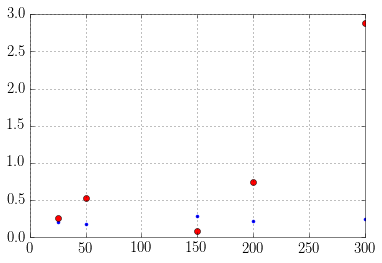

In [8]:
stds = []
mdiffs = []
for i, evrats in enumerate(evratsnest):
    stds.append(np.std(evrats))
    mdiffs.append(np.abs(np.mean(evrats)-evratsgrid[i]))

pl.plot(snrs[0:5], stds, '.')
pl.plot(snrs[0:5], mdiffs, 'ro')

In [9]:
stds

[0.20236052657919237,
 0.17551160901079776,
 0.29016779277893201,
 0.22806404642256195,
 0.24503516474784295]